In [17]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt
import os
import sys
import pathlib
from matplotlib import colors as mcolors

In [2]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
N_channels = 40
data_path = os.getcwd()

In [4]:
### IMPORT, SHUFFLE AND SCALE DATA ###
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [5]:
file_path = f'{data_path}/Data/10000_initial_data.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)

In [6]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
    hp_regularizer = hp.Choice('regularizer_penalty', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=56, max_value=200, step=4), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [7]:
### CREATE HYPERBAND TUNER ###

tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_mean_squared_error', 'min'),
                     max_epochs=100,
                     factor=3,
                     directory=data_path,
                     project_name='tuned_ANN',
                     overwrite=True,
                     seed=8)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5)

In [8]:
### SEARCHING FOR THE OPTIMAL ANN ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.2, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Trial 254 Complete [00h 00m 14s]
val_mean_squared_error: 0.006495912559330463

Best val_mean_squared_error So Far: 0.00018903274030890316
Total elapsed time: 00h 10m 43s
INFO:tensorflow:Oracle triggered exit
643.4013319015503


In [9]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Tuned model trained for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=100, shuffle=True, validation_split=0.2, verbose=2)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Tuned model trained for optimum number of epochs
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.2, verbose=2)

Epoch 1/100
250/250 - 0s - loss: 0.2019 - mean_squared_error: 0.2016 - mean_absolute_error: 0.4348 - val_loss: 0.1816 - val_mean_squared_error: 0.1814 - val_mean_absolute_error: 0.4065
Epoch 2/100
250/250 - 0s - loss: 0.1545 - mean_squared_error: 0.1542 - mean_absolute_error: 0.3657 - val_loss: 0.1332 - val_mean_squared_error: 0.1329 - val_mean_absolute_error: 0.3310
Epoch 3/100
250/250 - 0s - loss: 0.1169 - mean_squared_error: 0.1167 - mean_absolute_error: 0.3011 - val_loss: 0.1060 - val_mean_squared_error: 0.1057 - val_mean_absolute_error: 0.2817
Epoch 4/100
250/250 - 0s - loss: 0.0925 - mean_squared_error: 0.0923 - mean_absolute_error: 0.2622 - val_loss: 0.0834 - val_mean_squared_error: 0.0831 - val_mean_absolute_error: 0.2488
Epoch 5/100
250/250 - 0s - loss: 0.0724 - mean_squared_error: 0.0721 - mean_absolute_error: 0.2297 - val_loss: 0.0653 - val_mean_squared_error: 0.0650 - val_mean_absolute_error: 0.2186
Epoch 6/100
250/250 - 0s - loss: 0.0564 - mean_squared_error: 0.0561 - mean

Epoch 45/100
250/250 - 0s - loss: 9.6448e-04 - mean_squared_error: 3.3178e-04 - mean_absolute_error: 0.0139 - val_loss: 9.6133e-04 - val_mean_squared_error: 3.2736e-04 - val_mean_absolute_error: 0.0137
Epoch 46/100
250/250 - 0s - loss: 9.5004e-04 - mean_squared_error: 3.1486e-04 - mean_absolute_error: 0.0135 - val_loss: 9.4461e-04 - val_mean_squared_error: 3.0828e-04 - val_mean_absolute_error: 0.0131
Epoch 47/100
250/250 - 0s - loss: 9.4136e-04 - mean_squared_error: 3.0388e-04 - mean_absolute_error: 0.0133 - val_loss: 9.3828e-04 - val_mean_squared_error: 2.9971e-04 - val_mean_absolute_error: 0.0130
Epoch 48/100
250/250 - 0s - loss: 9.3288e-04 - mean_squared_error: 2.9324e-04 - mean_absolute_error: 0.0130 - val_loss: 9.2967e-04 - val_mean_squared_error: 2.8900e-04 - val_mean_absolute_error: 0.0125
Epoch 49/100
250/250 - 0s - loss: 9.2992e-04 - mean_squared_error: 2.8829e-04 - mean_absolute_error: 0.0129 - val_loss: 9.2964e-04 - val_mean_squared_error: 2.8708e-04 - val_mean_absolute_erro

Epoch 86/100
250/250 - 0s - loss: 8.5710e-04 - mean_squared_error: 1.9411e-04 - mean_absolute_error: 0.0103 - val_loss: 8.9802e-04 - val_mean_squared_error: 2.3499e-04 - val_mean_absolute_error: 0.0108
Epoch 87/100
250/250 - 0s - loss: 8.7371e-04 - mean_squared_error: 2.1071e-04 - mean_absolute_error: 0.0106 - val_loss: 8.7509e-04 - val_mean_squared_error: 2.1208e-04 - val_mean_absolute_error: 0.0102
Epoch 88/100
250/250 - 0s - loss: 8.6829e-04 - mean_squared_error: 2.0529e-04 - mean_absolute_error: 0.0105 - val_loss: 8.7336e-04 - val_mean_squared_error: 2.1038e-04 - val_mean_absolute_error: 0.0102
Epoch 89/100
250/250 - 0s - loss: 8.5614e-04 - mean_squared_error: 1.9313e-04 - mean_absolute_error: 0.0102 - val_loss: 8.5376e-04 - val_mean_squared_error: 1.9070e-04 - val_mean_absolute_error: 0.0099
Epoch 90/100
250/250 - 0s - loss: 8.5055e-04 - mean_squared_error: 1.8748e-04 - mean_absolute_error: 0.0101 - val_loss: 8.5997e-04 - val_mean_squared_error: 1.9685e-04 - val_mean_absolute_erro

Epoch 29/98
250/250 - 0s - loss: 0.0017 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0274 - val_loss: 0.0016 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0265
Epoch 30/98
250/250 - 0s - loss: 0.0016 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0261 - val_loss: 0.0015 - val_mean_squared_error: 9.5300e-04 - val_mean_absolute_error: 0.0249
Epoch 31/98
250/250 - 0s - loss: 0.0015 - mean_squared_error: 9.3562e-04 - mean_absolute_error: 0.0247 - val_loss: 0.0015 - val_mean_squared_error: 8.9870e-04 - val_mean_absolute_error: 0.0241
Epoch 32/98
250/250 - 0s - loss: 0.0014 - mean_squared_error: 8.6589e-04 - mean_absolute_error: 0.0237 - val_loss: 0.0014 - val_mean_squared_error: 7.9168e-04 - val_mean_absolute_error: 0.0224
Epoch 33/98
250/250 - 0s - loss: 0.0014 - mean_squared_error: 7.8237e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0013 - val_mean_squared_error: 7.2688e-04 - val_mean_absolute_error: 0.0213
Epoch 34/98
250/250 - 0s - loss: 0.0013 - mean_

Epoch 71/98
250/250 - 0s - loss: 8.8776e-04 - mean_squared_error: 2.3032e-04 - mean_absolute_error: 0.0112 - val_loss: 9.7180e-04 - val_mean_squared_error: 3.1424e-04 - val_mean_absolute_error: 0.0127
Epoch 72/98
250/250 - 0s - loss: 8.6411e-04 - mean_squared_error: 2.0643e-04 - mean_absolute_error: 0.0107 - val_loss: 8.9961e-04 - val_mean_squared_error: 2.4176e-04 - val_mean_absolute_error: 0.0111
Epoch 73/98
250/250 - 0s - loss: 8.5890e-04 - mean_squared_error: 2.0095e-04 - mean_absolute_error: 0.0105 - val_loss: 8.6239e-04 - val_mean_squared_error: 2.0426e-04 - val_mean_absolute_error: 0.0103
Epoch 74/98
250/250 - 0s - loss: 8.6918e-04 - mean_squared_error: 2.1094e-04 - mean_absolute_error: 0.0108 - val_loss: 8.6200e-04 - val_mean_squared_error: 2.0367e-04 - val_mean_absolute_error: 0.0103
Epoch 75/98
250/250 - 0s - loss: 8.5906e-04 - mean_squared_error: 2.0060e-04 - mean_absolute_error: 0.0105 - val_loss: 8.6093e-04 - val_mean_squared_error: 2.0236e-04 - val_mean_absolute_error: 0.

In [10]:
for key, value in best_hps.__dict__['values'].items():
    print(f'- {key}: {value}')

- regularizer_penalty: 1e-06
- n_layers: 2
- hidden_0_units: 140
- learning_rate: 0.0001
- hidden_1_units: 100
- tuner/epochs: 150
- tuner/initial_epoch: 50
- tuner/bracket: 1
- tuner/round: 1
- tuner/trial_id: 548e49ec3a5079ff0e443c74a390d49b


In [40]:
file_path = f'{data_path}/Data/10000_initial_data_testing.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
print(f'MSE test: {eval_result}')

MSE test: 0.00017492468759883195


In [12]:
def visualising_data_MSE(hist, name):
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

def visualising_data_MAE(hist, name):
    plt.plot(hist.history['mean_absolute_error'], label='Train')
    plt.plot(hist.history['val_mean_absolute_error'], label='Validation')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

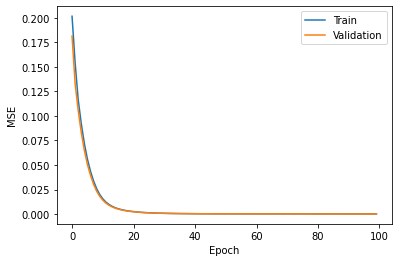

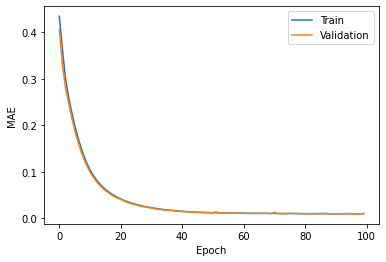

In [13]:
visualising_data_MSE(history, f'{data_path}/Figures/full_epochs_results_MSE.svg')
visualising_data_MAE(history, f'{data_path}/Figures/full_epochs_results_MAE.svg')

In [14]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               5880      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               14100     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________


In [15]:
hypermodel.save(f'{data_path}/Tuned_ANN_model.h5')

# CDF

In [34]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [30]:
def CDF_plot(x, y, name, e_type):
    mse_ecdf = plt.plot(x,y, marker='.', linestyle='none', color=colors['blue'])
    plt.xlabel(f'{e_type} [dB]')
    plt.ylabel('Probability')
    plt.savefig(f'{data_path}/Figures/{name}.svg', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

In [31]:
model = keras.models.load_model(f'{data_path}/Tuned_ANN_model.h5')
df = pd.read_csv(f'{data_path}/Data/10000_initial_data_testing.csv')
# dataset
dataset = df.values
# input power and channels statuses
X = dataset[:,0:N_channels+1]
Y = dataset[:,N_channels+1:2*N_channels+1]

xScaler = preprocessing.MinMaxScaler()
yScaler = preprocessing.MinMaxScaler()

xScaler.fit(X)
yScaler.fit(Y)

xTrainNorm = xScaler.transform(X)
yTrainNorm = yScaler.transform(Y)

start_time = time.time()
y_predicted = model.predict(xTrainNorm)
y_predicted_inverted = yScaler.inverse_transform(y_predicted)
prediction_time = time.time() - start_time
print(prediction_time)

0.14397001266479492


90th percentile mse =  0.16325716183053002 dB
90th percentile mae =  0.372598829589338 dB


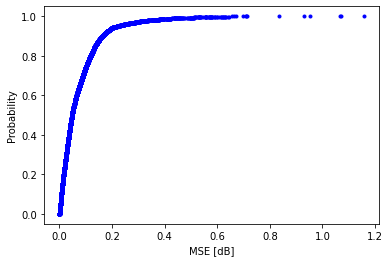

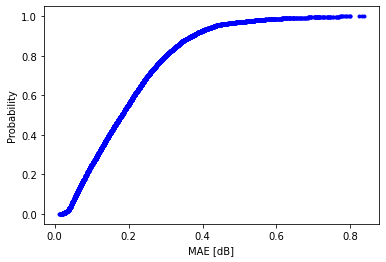

In [32]:
mean_squared_error_store = []
mean_absolute_error_store = []
for i in range(10000):
    mean_squared_error_store.append(mean_squared_error(y_predicted_inverted[i], Y[i]))
    mean_absolute_error_store.append(mean_absolute_error(y_predicted_inverted[i], Y[i]))
x_mse = np.sort(mean_squared_error_store)
x_mae = np.sort(mean_absolute_error_store)
y = np.arange(1, len(x_mse)+1)/len(x_mse)
print('90th percentile mse = ', x_mse[9000],'dB')
print('90th percentile mae = ', x_mae[9000],'dB')
CDF_plot(x_mse, y, 'CDF_tuned_ANN_MSE', 'MSE')
CDF_plot(x_mae, y, 'CDF_tuned_ANN_MAE', 'MAE')

# Bar plot

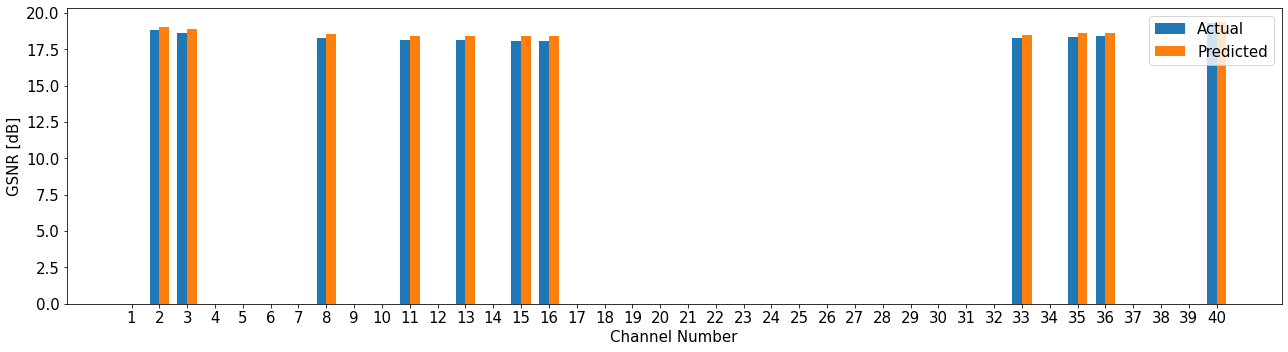

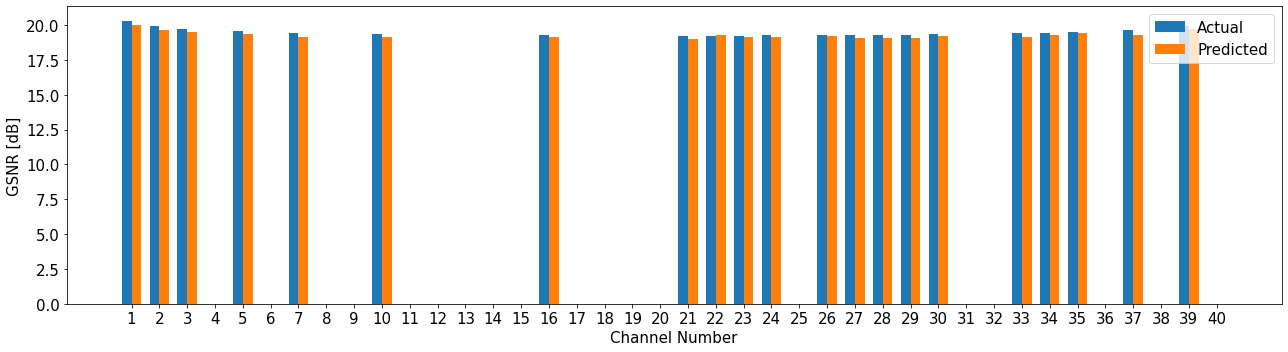

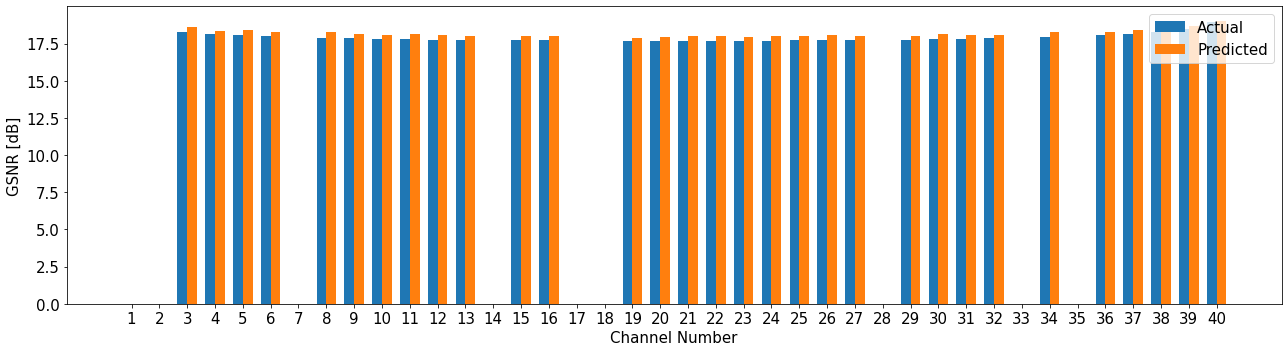

In [33]:
def barplot(index):
    y_actual = Y[index] * X[index][1:]
    y_predicted = y_predicted_inverted[index] * X[index][1:]
    
    labels = [i for i in range(1,41)]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(18,5))
    # plt.figure(figsize=(25,5))
    rects1 = ax.bar(x - width/2, y_actual, width, label='Actual')
    rects2 = ax.bar(x + width/2, y_predicted, width, label='Predicted')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('GSNR [dB]', fontsize=15)
    ax.set_xlabel('Channel Number', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.set_yticklabels(labels, fontsize=12)
    ax.legend(fontsize=15, loc='upper right')

    fig.tight_layout()

    plt.savefig(f'{data_path}/Figures/tuned_channel_bar_chart_{index}.svg', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

barplot(2500)
barplot(5100)
barplot(7500)